## City of Detroit Blight Violations - Payment predicting model.

This is a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. Our task is to predict whether a given blight ticket will be paid on time.

Related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

Two data files will be used in training and validating the models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

<br>

**File descriptions** (Use only this data for training your model!)

    data/train.csv - the training set (all tickets issued 2004-2011)
    data/test.csv - the test set (all tickets issued 2012-2016)
<br>

**Data fields**

*train.csv & test.csv*

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
*train.csv only*

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

Predictions will be given as the probability that the corresponding blight ticket will be paid on time.

In [16]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

***
**Only the train.csv will be used to build and test the model.**  
   *train.csv - the training set (all tickets issued 2004-2011)*
***

In [3]:
train_df_init = pd.read_csv('train.csv',engine='python') #or  pd.read_csv('train.csv',encoding = "ISO-8859-1")
test_df_init  = pd.read_csv('test.csv',engine='python')

In [4]:
train_df_init.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,MI,48214,NaN,USA,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,MI,48206,NaN,USA,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [6]:
# Data clean up & feature Engineering
train_df = train_df_init.copy()
test_df = test_df_init.copy()

train_df.sort_values(by='ticket_id',ascending=True, inplace=True)

# Drop all the columns that are only in Training set but not in Test set, except for the label: compliance. 
column_diff = train_df.columns.difference(test_df.columns)
drop_col = column_diff.drop('compliance') 
train_df.drop(drop_col, axis = 1, inplace=True)

# Drop all the other columns that will enable our model to generalize more vs overfitting for a specific instance.
train_df.drop(['ticket_id','inspector_name','violator_name','violation_street_number','violation_description',
               'violation_zip_code','mailing_address_str_number','mailing_address_str_name','city','state','non_us_str_code',
               'country','ticket_issued_date','hearing_date','admin_fee','state_fee','late_fee','discount_amount',
               'clean_up_cost','grafitti_status'
                ], axis=1, inplace=True)

# Deleting all the instances where there is no label/compliance information/
train_df.dropna(axis=0, subset=['compliance'], inplace=True)
train_df.reset_index(inplace=True)
train_df.drop(['index'], axis=1, inplace=True)

train_features = train_df.iloc[:,0:-1]
train_label = train_df.iloc[:,-1]

# Assign labels to the categorical data
train_features = train_features.fillna('') #or else: TypeError: argument must be a string or number. Need to remove NaN
train_features_object = train_features.select_dtypes(include=[object]) #object type columns
train_features_number = train_features.select_dtypes(exclude=[object]) #int and float columns

le = LabelEncoder()
train_features_le = train_features_object.apply(le.fit_transform)

train_df_final = pd.concat([train_features_le, train_features_number], axis=1)

# Splitting the data for train & testing purposes
X_train, X_test, y_train, y_test = train_test_split(train_df_final,train_label, random_state=0)

# Will be used for Cross validation method to do the splits.
train_features_value_arr = train_df_final.values
train_labels_value_arr = train_label.values

***
**Train a dummy classifier(majority) to set a benchmark target.**
***

In [7]:
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
# Cross fold validation on the training set. 5 folds (default).
cv_scores_dummy = cross_val_score(dummy_majority, train_features_value_arr, train_labels_value_arr);
# Evaluate the test set scores
dummy_test_score = dummy_majority.score(X_test, y_test)

print('Cross validation scores for Dummy classifier:{} '.format(cv_scores_dummy))
print('Mean of cv scores:{} '.format(np.mean(cv_scores_dummy)))
print('Test Set score:{} '.format(dummy_test_score))

Cross validation scores for Dummy classifier:[0.92747686 0.92747686 0.92747686 0.92744558 0.92744558] 
Mean of cv scores:0.9274643482611958 
Test Set score:0.9284213159869903 


***
**Train four different classifiers and evalute their performance.**  
  1. *Linear Support Vector Machine Classifier.*   
  2. *Logistic Regression Classifier.*  
  3. *Random Forest Classifier.*  
  4. *Decision Tree Classifier.*
***

***
**Train a Linear Support Vector Machine Classifier.**  
 *Perform basic five fold cross validation to evalute it's performance.* 
***

In [10]:
# Train a Linear Support Vector Machine Classifier
SVC_classifier = LinearSVC().fit(X_train, y_train);
# Cross fold validation on the training set. 5 folds (default).
cv_scores_LinearSVC = cross_val_score(SVC_classifier, train_features_value_arr, train_labels_value_arr);
# Evaluate the test set scores
test_score = SVC_classifier.score(X_test,y_test);

print('Cross validation scores for Linear SVC:{} '.format(cv_scores_LinearSVC))
print('Mean of cv scores:{} '.format(np.mean(cv_scores_LinearSVC)))
print('Test Set score:{} '.format(test_score))

C:\Users\Manoj\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Manoj\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Manoj\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Manoj\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Manoj\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

Cross validation scores for Linear SVC:[0.9271954  0.92894671 0.92785214 0.92747686 0.92688266] 
Mean of cv scores:0.9276707530647986 
Test Set score:0.9281961471103327 


C:\Users\Manoj\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


***
**Train a Logistic Regression Classifier.**  
 *Perform basic five fold cross validation to evalute it's performance.* 
***

In [11]:
# Train a Logistic Regression Classifier
logistic_classifier = LogisticRegression(max_iter=10000).fit(X_train, y_train);
# Cross fold validation on the training set. 5 folds (default).
cv_scores_logistic = cross_val_score(logistic_classifier, train_features_value_arr, train_labels_value_arr);
# Evaluate the test set scores
test_score = logistic_classifier.score(X_test,y_test);

print('Cross validation scores for LogisticRegression Classifier:{} '.format(cv_scores_logistic))
print('Mean of cv scores:{} '.format(np.mean(cv_scores_logistic)))
print('Test Set score:{} '.format(test_score))

Cross validation scores for LogisticRegression Classifier:[0.92663247 0.92778959 0.92772705 0.92757068 0.92603828] 
Mean of cv scores:0.9271516137102827 
Test Set score:0.9289216912684514 


***
**Train a Random Forest Classifier.**  
 *Perform basic five fold cross validation to evalute it's performance.* 
***

In [13]:
# Train a Random Forest Classifier
randomForest_classifier = RandomForestClassifier(max_features = 2, random_state = 0).fit(X_train, y_train);
# Cross fold validation on the training set. 5 folds (default).
cv_scores_forest = cross_val_score(randomForest_classifier, train_features_value_arr, train_labels_value_arr);
# Evaluate the test set scores
test_score = randomForest_classifier.score(X_test,y_test);

print('Cross validation scores for Random Forest:{} '.format(cv_scores_forest))
print('Mean of cv scores:{} '.format(np.mean(cv_scores_forest)))
print('Test Set score:{} '.format(test_score))

Cross validation scores for Random Forest:[0.90502252 0.92275457 0.92738304 0.92935326 0.92782087] 
Mean of cv scores:0.9224668501376033 
Test Set score:0.9287215411558669 


***
**Train a Decision Tree Classifier.**  
 *Perform basic five fold cross validation to evalute it's performance.* 
***

In [15]:
# Train a Decision Tree Classifier
tree_classifier = DecisionTreeClassifier(max_depth=5,random_state=0).fit(X_train, y_train);
# Cross fold validation on the training set. 5 folds (default).
cv_scores_tree = cross_val_score(tree_classifier, train_features_value_arr, train_labels_value_arr);
# Evaluate the test set scores
test_score_decision_tree = tree_classifier.score(X_test,y_test) # 0.9577

print('Cross validation scores for Tree Classifier:{} '.format(cv_scores_tree))
print('Mean of cv scores:{} '.format(np.mean(cv_scores_tree)))
print('Test Set score:{} '.format(test_score_decision_tree))

Cross validation scores for Tree Classifier:[0.92885289 0.92782087 0.9331999  0.93176132 0.92925944] 
Mean of cv scores:0.9301788841631223 
Test Set score:0.9335751813860396 


***
**Train a Gradient-boosted decision Tree Classifier.**  
 *Perform basic five fold cross validation to evalute it's performance.* 
***

In [66]:
# Train a Gradient Boosted Decision Tree Classifier
gradient_classifier = GradientBoostingClassifier(random_state=0).fit(X_train, y_train);
# Cross fold validation on the training set. 5 folds (default).
cv_scores_gradient = cross_val_score(gradient_classifier, train_features_value_arr, train_labels_value_arr);
# Evaluate the test set scores
test_score_gradient = gradient_classifier.score(X_test,y_test) # 0.9577

print('Cross validation scores for Tree Classifier:{} '.format(cv_scores_gradient))
print('Mean of cv scores:{} '.format(np.mean(cv_scores_gradient)))
print('Test Set score:{} '.format(test_score_gradient))

Cross validation scores for Tree Classifier:[0.9275394  0.93082312 0.93648361 0.93876657 0.93898549] 
Mean of cv scores:0.9345196397297973 
Test Set score:0.9362521891418564 


***
**Print the confusion matricies for DecisionTree, Gradient-boosted DT & other metrics for LinearSVC & LogisticRegression models.**  
*Use the Decision Function to find the confidence scores.*
***

In [23]:
# Check the confusion matrix for the Decision Tree classifier
y_tree_predicted = tree_classifier.predict(X_test)
print(confusion_matrix(y_test, y_tree_predicted))

[[36932   177]
 [ 1512  1349]]


In [18]:
# Check the confusion matrix for the Gradient Boosted Decision Tree Classifier
y_gradient_predicted = gradient_classifier.predict(X_test)
print(confusion_matrix(y_test, y_gradient_predicted))

[[37081    28]
 [ 2520   341]]


In [21]:
# Check the confusion matrix for the Linear SVC classifier
y_svc_predicted = SVC_classifier.predict(X_test)
print(confusion_matrix(y_test, y_svc_predicted))

# Find the FalsePositiveRate, TruePositiveRate and the area under ROC curve.
y_confidence_svc = SVC_classifier.decision_function(X_test);
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_confidence_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)
print('Area Under the Curve: {}.'.format(roc_auc_svc))

[[37005   104]
 [ 2766    95]]
Area Under the Curve: 0.7628703735876425.


In [22]:
# Check the confusion matrix for the Logistic Regression classifier
y_logistic_predicted = logistic_classifier.predict(X_test)
print(confusion_matrix(y_test, y_logistic_predicted))

# Find the FalsePositiveRate, TruePositiveRate and the area under ROC curve.
y_confidence_log = logistic_classifier.decision_function(X_test);
fpr_log, tpr_log, _ = roc_curve(y_test, y_confidence_log)
roc_auc_log = auc(fpr_log, tpr_log)
print('Area Under the Curve: {}.'.format(roc_auc_log))

[[37005   104]
 [ 2737   124]]
Area Under the Curve: 0.7558425306089549.


***
**Plot a *Precision-Recall* curve to visualize the metrics. Training Set**
***

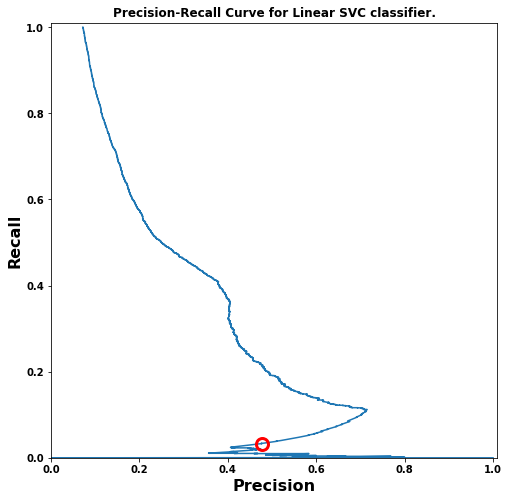

In [23]:
#Linear SVC classifier
precision, recall, thresholds = precision_recall_curve(y_test, y_confidence_svc)

closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure(figsize=(8,8))
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall)
plt.title('Precision-Recall Curve for Linear SVC classifier.')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.show()

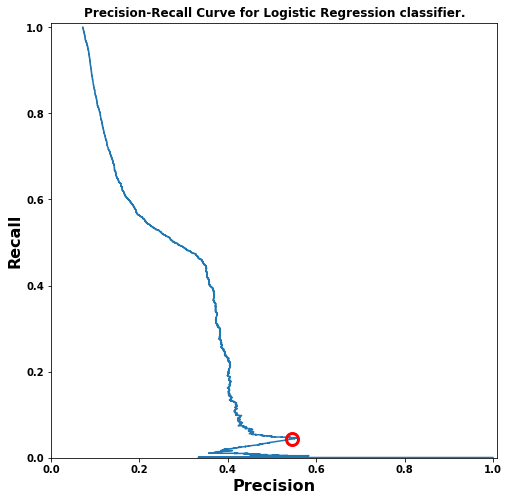

In [24]:
#Logistic Regression classifier
precision, recall, thresholds = precision_recall_curve(y_test, y_confidence_log)

closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure(figsize=(8,8))
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall)
plt.title('Precision-Recall Curve for Logistic Regression classifier.')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.show()

***
**Plot a *ROC* curve, for the confidence scores. Training Set**
***

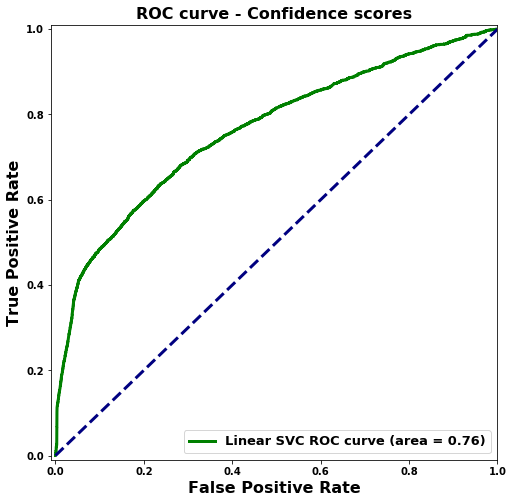

Area under the curve: 0.7628703735876425


In [25]:
# Linear SVC classifier
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_svc, tpr_svc, color='green',lw=3, label='Linear SVC ROC curve (area = {:0.2f})'.format(roc_auc_svc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - Confidence scores', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.show()
print('Area under the curve: {}'.format(roc_auc_svc))

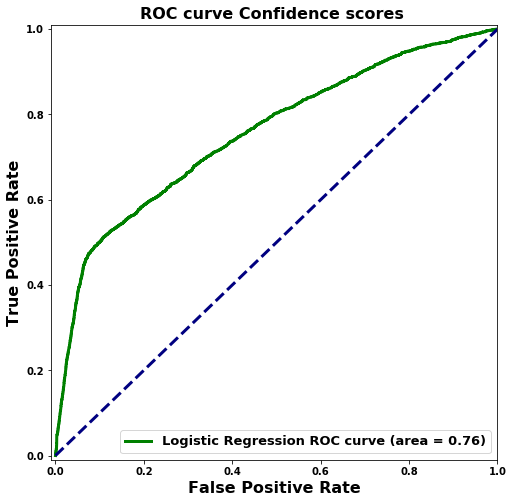

Area under the curve: 0.7558425306089549


In [26]:
# Logistic Regression classifier
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_log, tpr_log, color='green',lw=3, label='Logistic Regression ROC curve (area = {:0.2f})'.format(roc_auc_log))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve Confidence scores ', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.show()
print('Area under the curve: {}'.format(roc_auc_log))

***
**Plot a *ROC* curve, for the predicted probabilities. Training Set**
***

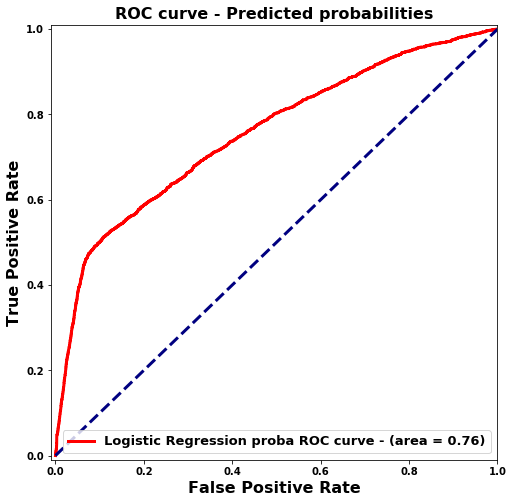

Area under the curve: 0.7628703735876425


In [39]:
#Logistic Regression Classifier.
y_proba_log = logistic_classifier.predict_proba(X_test)
fpr_pro_log, tpr_pro_log, _ = roc_curve(y_test, y_proba_log[:,1])
roc_auc_pro_log = auc(fpr_pro_log, tpr_pro_log)

plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_pro_log, tpr_pro_log, color='red',lw=3, label='Logistic Regression proba ROC curve - (area = {:0.2f})'.format(roc_auc_pro_log))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - Predicted probabilities', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.show()
print('Area under the curve: {}'.format(roc_auc_svc))

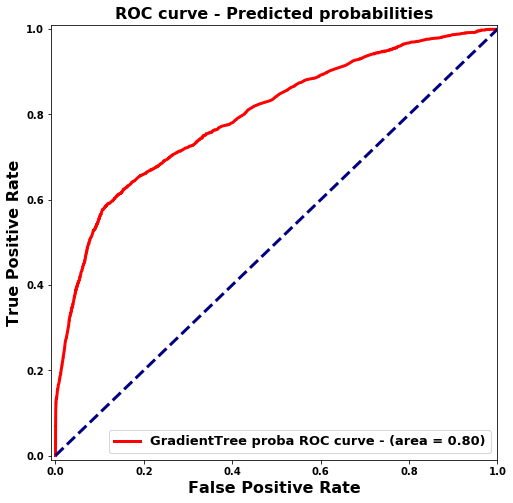

Area under the curve: 0.7628703735876425


In [44]:
# Gradient Decision Tree Classifier
y_proba_grad = gradient_classifier.predict_proba(X_test)
fpr_pro_grad, tpr_pro_grad, _ = roc_curve(y_test, y_proba_grad[:,1])
roc_auc_pro_grad= auc(fpr_pro_grad, tpr_pro_grad)

plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_pro_grad, tpr_pro_grad, color='red',lw=3, label='GradientTree proba ROC curve - (area = {:0.2f})'.format(roc_auc_pro_grad))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - Predicted probabilities', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.show()
print('Area under the curve: {}'.format(roc_auc_svc))

***
**Now, evaluate the Logistic Regression Classifier using the held out test set data (all tickets issued 2012-2016).**
***

In [36]:
test_df = test_df_init.copy()

# Data clean up & feature Engineering
test_df.sort_values(by='ticket_id',ascending=True, inplace=True)

# Drop the same set of columns that are removed from the training set.
test_df.drop(['inspector_name','violator_name','violation_street_number','violation_description',
               'violation_zip_code','mailing_address_str_number','mailing_address_str_name','city','state','non_us_str_code',
               'country','ticket_issued_date','hearing_date','admin_fee','state_fee','late_fee','discount_amount',
               'clean_up_cost','grafitti_status'
                ], axis=1, inplace=True)

# Assign labels to the categorical data
test_df.fillna('', inplace=True) #or else: TypeError: argument must be a string or number. Need to remove NaN
test_df_object = test_df.select_dtypes(include=[object]) #object type columns
test_df_number = test_df.select_dtypes(exclude=[object]) #int and float columns

le = LabelEncoder()
test_features_le = test_df_object.apply(le.fit_transform)

test_df_final = pd.concat([test_features_le, test_df_number], axis=1)
test_df_final.set_index('ticket_id', inplace=True)

In [38]:
test_df_final.head()

,agency_name,violation_street_name,zip_code,violation_code,disposition,fine_amount,judgment_amount
ticket_id,,,,,,,
284932,1,1181,1317,31,5,200.0,250.0
284943,1,1358,1327,48,5,1000.0,1130.0
284944,1,820,957,21,5,100.0,140.0
284945,1,119,1531,48,5,1000.0,1130.0
284946,1,993,1562,48,6,100.0,140.0


***
**Find the Probabilities of a ticket being paid, using the Gradient Boosted Decision Tree Classifier. Test Set.**
***

In [71]:
y_proba_gradient = gradient_classifier.predict_proba(test_df_final)
compliance_gradient = pd.Series( data =y_proba_gradient[:,1], index=(test_df_final.index))
compliance_gradient

ticket_id
284932    0.391904
284943    0.145633
284944    0.306103
284945    0.134712
284946    0.331167
            ...   
376622    0.308734
376623    0.653584
376624    0.963448
376638    0.823124
376698    0.207016
Length: 61001, dtype: float64